# Time series project

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import networkx as nx
from collections import deque, OrderedDict

Useful function to calculate Laplacian and its conjugate.

In [58]:
def edge_list(p: int):
    """
    Returns list of (i,j) pairs with i>j in a fixed order.
    Length = p*(p-1)//2
    """
    edges = []
    for j in range(p):
        for i in range(j+1, p):
            edges.append((i, j))

    edges = np.array(edges)
    return edges

def L_operator(w: np.ndarray, p: int, edges=None) -> np.ndarray:
    """
    Laplacian operator L: 
    Builds Theta = Lw such that:
      Theta_ij = -w_k for (i,j) edge with i>j
      Theta is symmetric
      Theta_ii = -sum_{j!=i} Theta_ij  (so rows sum to 0)
    Matches Definition of Laplacian set S_Theta and operator L.  (paper Sec 3.1)

    See the paper for more information, specifically [page 13] !
    """

    if edges is None:
        edges = edge_list(p)
    m = p * (p - 1) // 2
    assert w.shape == (m,), f"w must have shape ({m},), got {w.shape}"

    Theta = np.zeros((p, p))
    for k, (i, j) in enumerate(edges):

        Theta[i, j] = -w[k]
        Theta[j, i] = -w[k]

    Theta[np.diag_indices(p)] = -Theta.sum(axis=1)

    return Theta

def L_adjoint(Y: np.ndarray, p: int, edges=None) -> np.ndarray:

    """
    Adjoint operator L*: 
    For each edge (i>j), returns:
      [L*Y]_k = Y_ii - Y_ij - Y_ji + Y_jj

    See paper for adjoint formula, specifically [page 14]
    """

    if edges is None:
        edges = edge_list(p)

    assert Y.shape == (p, p), f"Y must have shape ({p},{p}), got {Y.shape}"

    m = p * (p - 1) // 2
    out = np.zeros(m)

    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, i] - Y[i, j] - Y[j, i] + Y[j, j]

    return out

def adjacency_from_theta(theta: np.ndarray):
    """
    For Laplacian Theta:
      off-diagonals are negative weights: Theta[i,j] = -w_ij
    """
    W = np.maximum(-theta, 0.0)
    thr = np.quantile(W[W > 0], 0.90)
    print(f"The threshold is: {thr}") 
    np.fill_diagonal(W, 0.0)
    W[W < thr] = 0.0
    return W

Test the correctess of the Adjoint and the Laplacian Matrix

In [59]:
p = 100
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
Theta = L_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(Theta * Y)  
right = np.dot(w, L_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 4.656612873077393e-10


We can see that the scalar product is preserved, so the adjoint formula is correct. This part here plots the connected compoennt and shows the eigen values representing the numbe of connected compoenents.

Connected components (networkx): 3
Connected components (spectral): 3
Smallest eigenvalues: [1.44707442e-15 2.56987923e-15 1.20337768e-14 1.84663778e+00
 2.13664100e+00 2.27591909e+00 2.31141836e+00 2.71769732e+00
 2.99134810e+00 3.12666128e+00]


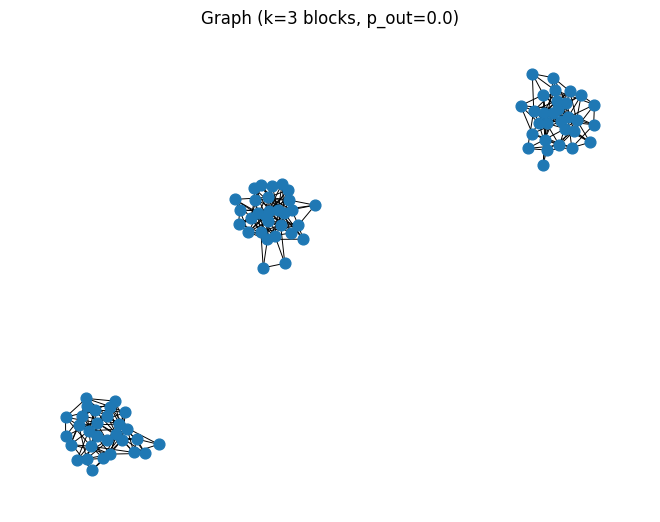

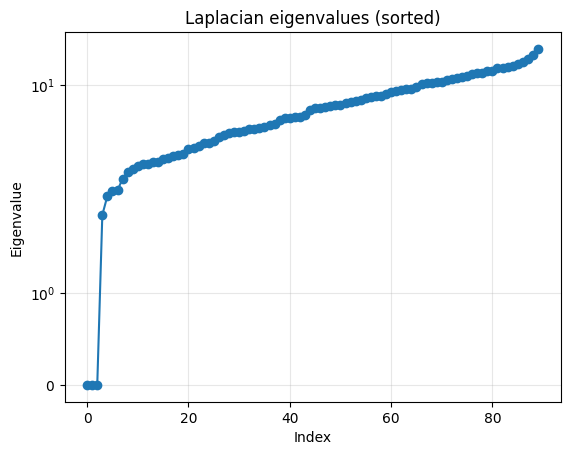

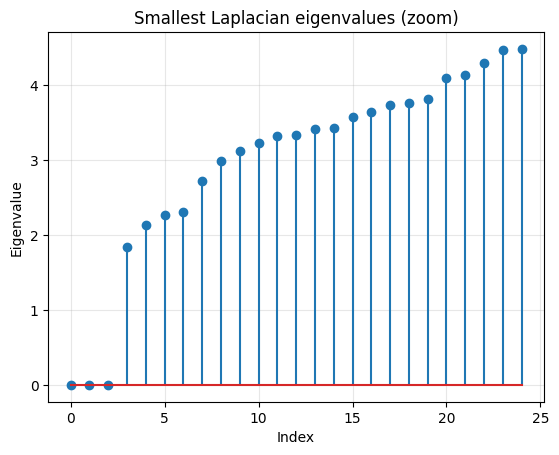

In [60]:
def laplacian_from_W(W: np.ndarray):
    """ Laplacian L = D - W.
    
        W : Adjacency matrix of the graph 
    """
    D = np.diag(W.sum(axis=1))
    return D - W

def normalized_laplacian_from_W(W: np.ndarray):

    """Normalized Laplacian L_sym = I - D^{-1/2} W D^{-1/2}."""
    
    d = W.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))

    I = np.eye(W.shape[0])
    # Formula in tp altegrad
    return I - D_inv_sqrt @ W @ D_inv_sqrt

def count_components_from_eigs(eigs, tol=1e-8):
    """#components = multiplicity of eigenvalue 0 (within tolerance)."""
    return int(np.sum(eigs < tol))

# -----------------------------
# Generate a graph with k connected components
# -----------------------------
n_per = 30
k = 3
p_in = 0.25   
p_out = 0.0   

sizes = [n_per] * k
P = np.full((k, k), p_out)
np.fill_diagonal(P, p_in)

G = nx.stochastic_block_model(sizes, P)
W = nx.to_numpy_array(G, weight=None)
np.fill_diagonal(W, 0.0)

# -----------------------------
# Laplacian and eigenvalues
# -----------------------------
L = laplacian_from_W(W) 

eigs = np.linalg.eigvalsh(L)  
num_cc = nx.number_connected_components(G)
num_cc_from_spec = count_components_from_eigs(eigs, tol=1e-8)

print("Connected components (networkx):", num_cc)
print("Connected components (spectral):", num_cc_from_spec)
print("Smallest eigenvalues:", eigs[:10])

# -----------------------------
# Plot graph and eigenvalues
# -----------------------------
plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs))
plt.stem(range(m), eigs[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()


In [61]:
def laplacian_from_W(W: np.ndarray):
    D = np.diag(W.sum(axis=1))
    return D - W

def sample_igmrf(Theta: np.ndarray, n: int, rng=None):
    """
    Uses pseudo-inverse covariance.
    """
    if rng is None:
        rng = np.random.default_rng(0)
    Sigma = np.linalg.pinv(Theta)
    X = rng.multivariate_normal(mean=np.zeros(Theta.shape[0]), cov=Sigma, size=n)
    return X

def sample_covariance(X: np.ndarray):
    # matches (67) in the paper: centered sample covariance :contentReference[oaicite:6]{index=6}
    Xc = X - X.mean(axis=0, keepdims=True)
    return (Xc.T @ Xc) / Xc.shape[0]

In [62]:
def weights_from_theta(Theta: np.ndarray, edges):
    # Theta_ij = -w_ij for i!=j, w>=0
    w = np.zeros(len(edges), dtype=float)
    for k, (i, j) in enumerate(edges):
        w[k] = max(-Theta[i, j], 0.0)
    return w

def relative_error(Theta_hat, Theta_true):
    return np.linalg.norm(Theta_hat - Theta_true, ord="fro") / (np.linalg.norm(Theta_true, ord="fro") + 1e-12)

def support_from_weights_quantile(w, q=0.9):
    """Return boolean mask for top (1-q)% edges."""
    w = np.asarray(w)
    pos = w[w > 0]
    if len(pos) == 0:
        return np.zeros_like(w, dtype=bool)
    thr = np.quantile(pos, q)
    return w >= thr

def f_score_from_thetas(Theta_hat, Theta_true, edges, q=0.9):
    
    w_hat = weights_from_theta(Theta_hat, edges)
    w_true = weights_from_theta(Theta_true, edges)

    pred = support_from_weights_quantile(w_hat, q)
    true = w_true > 0

    tp = np.sum(pred & true)
    fp = np.sum(pred & ~true)
    fn = np.sum(~pred & true)

    denom = (2*tp + fp + fn)
    return (2*tp / denom) if denom > 0 else 1.0

### SGL
SGL Algorithm, implemting the first algorithm of lambda and the correspinding second for updating the eigen values.

In [63]:
def phi_log(w, eps : float):
    return np.log(eps + w)

def sgl_objective(S: np.ndarray,
                  Lw: np.ndarray,
                  w: np.ndarray,
                  U: np.ndarray,
                  lam: np.ndarray,
                  alpha: float,
                  beta: float,
                  eps: float,
                  phi) -> float:
    """
    F(w,lam,U) =
      - log gdet(Diag(lam)) + tr(S Lw) + alpha * sum_i phi(w_i)
      + (beta/2) * ||Lw - U Diag(lam) U^T||_F^2
    """
    lam = np.asarray(lam, dtype=float)
    if np.any(lam <= 0):
        return np.inf  

    term_gdet = -np.sum(np.log(lam))                 
    term_trace = float(np.trace(S @ Lw))             
    term_sparse = float(alpha * np.sum(phi(w, eps)))      

    B = U @ np.diag(lam) @ U.T
    term_pen = 0.5 * beta * (np.linalg.norm(Lw - B, ord="fro") ** 2)

    return term_gdet + term_trace + term_sparse + term_pen

In [64]:
def w_init_naive_from_S(S: np.ndarray, edges: np.ndarray) -> np.ndarray:
    """
    Repo's 'naive' init: w_ij = max(0, -pinv(S)_{ij})
    """
    Sinv = np.linalg.pinv(S)
    m = len(edges)
    w0 = np.zeros(m, dtype=float)
    for e, (i, j) in enumerate(edges):
        w0[e] = max(-Sinv[i, j], 0.0)
    # small epsilon to avoid degenerate Lw at start (optional)
    w0 += 1e-12
    return w0

In [65]:
def U_update(Lw: np.ndarray, k: int):
    evals, evecs = np.linalg.eigh(Lw)
    return evecs[:, k:], evals

In [66]:
def lambda_update_closed_form(d: np.ndarray, beta: float, c1: float, c2: float):
    d = np.asarray(d, dtype=float)
    lam = 0.5 * (d + np.sqrt(d*d + 4.0/beta))
    lam = np.clip(lam, c1, c2)

    # repo guardrail: lambda must be nondecreasing
    if np.any(np.diff(lam) < -1e-9):
        raise ValueError("lambda not nondecreasing; increase beta.")
    return lam

In [67]:
def apply_M(v: np.ndarray, p: int, edges: np.ndarray) -> np.ndarray:
    """
    M v = L*(L(v)), where L(v) is a Laplacian built from weight-vector v.
    """
    Lv = L_operator(v, p, edges)
    return L_adjoint(Lv, p, edges)

In [68]:
def w_update_repo_style(w: np.ndarray, Lw: np.ndarray, U: np.ndarray, lam: np.ndarray,
                        beta: float, K: np.ndarray, p: int, edges: np.ndarray) -> np.ndarray:
    """
    Mirrors R's laplacian.w_update:
      c = L*(U diag(lam) U^T - K/beta)
      grad_f = L*(Lw) - c
      t = (w^T M grad_f - c^T grad_f) / (grad_f^T M grad_f)
      w <- (w - t grad_f)_+
    """
    ULmdUT = U @ np.diag(lam) @ U.T
    c = L_adjoint(ULmdUT - (K / beta), p, edges)

    grad_f = L_adjoint(Lw, p, edges) - c
    M_grad_f = apply_M(grad_f, p, edges)

    denom = float(np.dot(grad_f, M_grad_f))
    if denom <= 1e-18 or not np.isfinite(denom):
        return np.maximum(w, 0.0)

    numer = float(np.dot(w, M_grad_f) - np.dot(c, grad_f))
    t = numer / denom

    w_new = np.maximum(w - t * grad_f, 0.0)
    return w_new

In [69]:
def sgl_r_style(S: np.ndarray,
                k: int,
                beta: float = 400.0,
                alpha: float = 0.1,
                eps: float = 1e-4,
                c1: float = 1e-9,
                c2: float = 1e9,
                maxiter: int = 200,
                reltol: float = 1e-6,
                w0: np.ndarray | None = None,
                verbose: bool = True):

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    edges = edge_list(p)
    m = len(edges)

    # ---- init w ----
    if w0 is None:
        w = w_init_naive_from_S(S, edges)   # IMPORTANT
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    # H and K (reweighted l1 surrogate) like repo
    H = alpha * (2 * np.eye(p) - np.ones((p, p)))

    # initial Lw, U, lam
    Lw = L_operator(w, p, edges)
    U, evals = U_update(Lw, k)
    d = np.diag(U.T @ Lw @ U)
    lam = lambda_update_closed_form(d, beta=beta, c1=c1, c2=c2)

    # K update (safe division)
    denom = (-Lw + eps)
    K = S + np.divide(H, denom, out=np.zeros_like(H), where=np.abs(denom) > 0)

    hist = {"relchg_w": [], "penalty": [], "eig_k": [], "step": []}

    for it in range(maxiter):
        w_old = w.copy()

        # ----- w-update (repo style) -----
        w = w_update_repo_style(w, Lw, U, lam, beta, K, p, edges)

        # ----- update Lw, U, lam -----
        Lw = L_operator(w, p, edges)
        U, evals = U_update(Lw, k)
        d = np.diag(U.T @ Lw @ U)
        lam = lambda_update_closed_form(d, beta=beta, c1=c1, c2=c2)

        # ----- update K (safe) -----
        # denom = (-Lw + eps)
        K = S + H

        # ----- logging / stopping -----
        relchg = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12)
        hist["relchg_w"].append(relchg)
        hist["penalty"].append(np.linalg.norm(Lw - U @ np.diag(lam) @ U.T, ord="fro"))
        hist["eig_k"].append(evals[k] if k < len(evals) else np.nan)

        if verbose and (it % 10 == 0 or it == maxiter - 1):
            print(f"[it={it:03d}] relchg(w)={relchg:.3e}, eig[k]={hist['eig_k'][-1]:.3e}")

        if relchg < reltol:
            break

    return Lw, w, U, lam, hist

Application to noisy graphs

In [70]:
def make_block_k_component_laplacian(p=64, k=4, w_low=0.0, w_high=1.0, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    sizes = [p // k] * k
    assert sum(sizes) == p

    W_true = np.zeros((p, p), dtype=float)
    start = 0
    for sz in sizes:
        idx = np.arange(start, start + sz)
        W = rng.uniform(w_low, w_high, size=(   sz, sz))
        W = 0.5 * (W + W.T)
        np.fill_diagonal(W, 0.0)
        W_true[np.ix_(idx, idx)] = W
        start += sz

    Theta_true = laplacian_from_W(W_true)
    return W_true, Theta_true

def make_er_noise_laplacian(p=64, p_edge=0.25, kappa=0.45, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    M = (rng.random((p, p)) < p_edge).astype(float)
    M = np.triu(M, 1)
    M = M + M.T

    W_er = rng.uniform(0.0, kappa, size=(p, p))
    W_er = 0.5 * (W_er + W_er.T)
    np.fill_diagonal(W_er, 0.0)
    W_er = M * W_er

    Theta_er = laplacian_from_W(W_er)
    return W_er, Theta_er


[it=000] relchg(w)=1.426e-02, eig[k]=2.085e+01
[it=010] relchg(w)=7.440e-03, eig[k]=1.889e+01
[it=020] relchg(w)=5.426e-03, eig[k]=1.769e+01
[it=030] relchg(w)=4.190e-03, eig[k]=1.712e+01
[it=040] relchg(w)=3.410e-03, eig[k]=1.663e+01
[it=050] relchg(w)=2.853e-03, eig[k]=1.625e+01
[it=060] relchg(w)=2.370e-03, eig[k]=1.597e+01
[it=070] relchg(w)=2.024e-03, eig[k]=1.576e+01
[it=080] relchg(w)=1.735e-03, eig[k]=1.564e+01
[it=090] relchg(w)=1.478e-03, eig[k]=1.555e+01
[it=100] relchg(w)=1.292e-03, eig[k]=1.547e+01
[it=110] relchg(w)=1.144e-03, eig[k]=1.540e+01
[it=120] relchg(w)=1.020e-03, eig[k]=1.534e+01
[it=130] relchg(w)=9.319e-04, eig[k]=1.529e+01
[it=140] relchg(w)=8.465e-04, eig[k]=1.525e+01
[it=150] relchg(w)=7.766e-04, eig[k]=1.522e+01
[it=160] relchg(w)=7.144e-04, eig[k]=1.519e+01
[it=170] relchg(w)=6.458e-04, eig[k]=1.516e+01
[it=180] relchg(w)=6.099e-04, eig[k]=1.513e+01
[it=190] relchg(w)=5.647e-04, eig[k]=1.511e+01
[it=200] relchg(w)=5.289e-04, eig[k]=1.509e+01
[it=210] relc

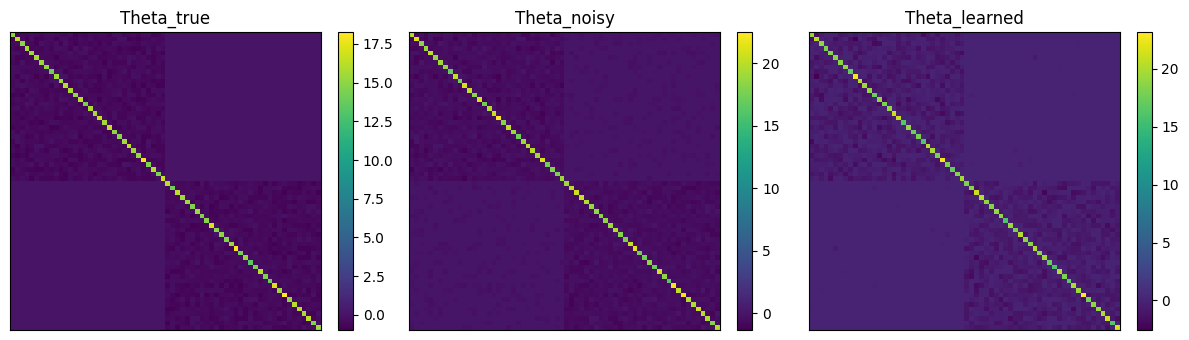

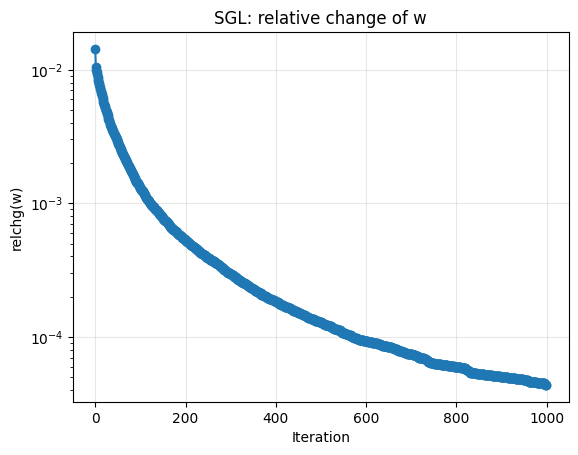

In [71]:
rng = np.random.default_rng(1)

p = 64
k_true = 2

# true multi-component Laplacian
W_true, Theta_true = make_block_k_component_laplacian(p=p, k=k_true, w_low=0.0, w_high=1.0, rng=rng)

# ER noise Laplacian (paper uses this corruption model)
W_er, Theta_er = make_er_noise_laplacian(p=p, p_edge=0.25, kappa=0.45, rng=rng)

Theta_noisy = Theta_true + Theta_er

# sample data from IGMRF and compute SCM (eq. 67)
n = 30 * p
X = sample_igmrf(Theta_noisy, n=n, rng=rng)
S = sample_covariance(X)

# run SGL (paper-like hyperparams for this scenario)
Theta_hat, w_hat, U_hat, lam_hat, hist = sgl_r_style(
    S, k=k_true,
    beta=400.0, alpha=0.1, eps=1e-4,
    c1=1e-9, c2=1e9,
    maxiter=1000, reltol=1e-6,
    verbose=True
)

# metrics
edges = edge_list(p)
re = relative_error(Theta_hat, Theta_true)
fs = f_score_from_thetas(Theta_hat, Theta_true, edges)
print(f"\nRE={re:.3f}, F-score={fs:.3f}")

# plots: heatmaps like the paper
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
for ax, M, title in zip(
    axes,
    [Theta_true, Theta_noisy, Theta_hat],
    ["Theta_true", "Theta_noisy", "Theta_learned"]
):
    im = ax.imshow(M, aspect="auto")
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

# convergence diagnostics
plt.figure()
plt.semilogy(hist["relchg_w"], marker="o")
plt.title("SGL: relative change of w")
plt.xlabel("Iteration")
plt.ylabel("relchg(w)")
plt.grid(True, alpha=0.3)
plt.show()


In [75]:
def adjacency_from_theta(Theta: np.ndarray, thr_quantile: float = 0.90) -> np.ndarray:
    """
    Recover adjacency matrix W from Laplacian Theta.
    Threshold by quantile on positive weights.
    """
    # off-diagonal weights
    W = np.maximum(-Theta, 0.0)
    np.fill_diagonal(W, 0.0)

    # threshold (to visualize / binarize structure)
    positive = W[W > 0]
    if positive.size == 0:
        return W

    thr = np.quantile(positive, thr_quantile)
    print(f"[adjacency_from_theta] threshold = {thr:.4g}")

    W[W < thr] = 0.0
    return W

[adjacency_from_theta] threshold = 1.29


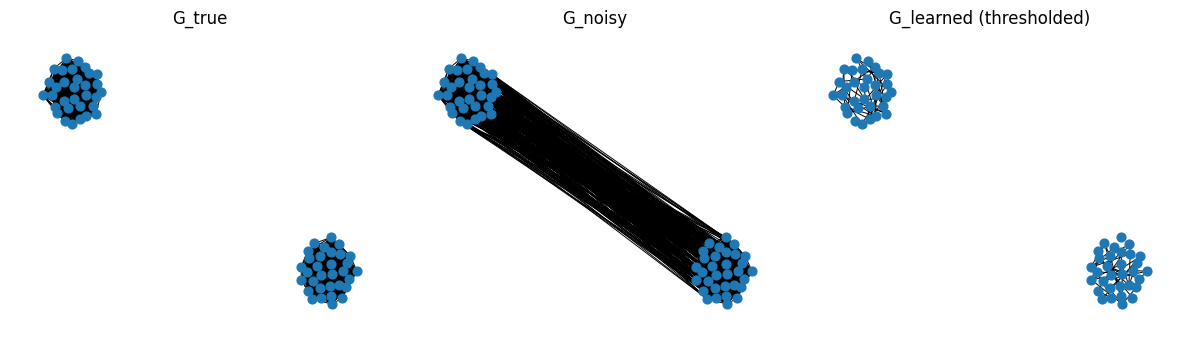

In [17]:
W_hat = adjacency_from_theta(Theta_hat, thr_quantile=0.90)

G_true = nx.from_numpy_array(np.maximum(W_true, 0.0))
G_noisy = nx.from_numpy_array(np.maximum(W_true + W_er, 0.0))
G_hat = nx.from_numpy_array(np.maximum(W_hat, 0.0))

pos = nx.spring_layout(G_true, seed=0)

plt.figure(figsize=(12, 3.5))

plt.subplot(1, 3, 1)
nx.draw(G_true, pos, node_size=40, width=0.7)
plt.title("G_true")
plt.axis("off")

plt.subplot(1, 3, 2)
nx.draw(G_noisy, pos, node_size=40, width=0.7)
plt.title("G_noisy")
plt.axis("off")

plt.subplot(1, 3, 3)
nx.draw(G_hat, pos, node_size=40, width=0.7)
plt.title("G_learned (thresholded)")
plt.axis("off")

plt.tight_layout()
plt.show()


### Animal Dataset

In [18]:
A_animals = np.loadtxt("./AwA2-base/Animals_with_Attributes2/predicate-matrix-binary.txt")  
with open("./AwA2-base/Animals_with_Attributes2/classes.txt", "r") as f:
    class_names = [line.strip() for line in f]

In [19]:
A_animals = np.asarray(A_animals)
print("A_animals shape:", A_animals.shape)

# convention: rows=features, cols=animals? you used transpose so keep same
X_animals = A_animals.T

mu = X_animals.mean(axis=0, keepdims=True)

Xz = (X_animals - mu) 

S_animals = (Xz.T @ Xz) / Xz.shape[0]
p = S_animals.shape[0]
print("S_animals shape:", S_animals.shape)

# small diagonal loading (like you did)
S_in_animals = S_animals + (1/3) * np.eye(p)

A_animals shape: (50, 85)
S_animals shape: (50, 50)


In [20]:
Theta_hat_animals, w_hat, U_hat, lam_hat, hist = sgl_r_style(
    S_in_animals,
    k=12,
    alpha=0.0,
    beta=0.5,
    eps=1e-3,
    c1=1e-3,
    c2=1e3,
    reltol=1e-5,
    maxiter=1000,
    verbose=True
)
W_hat_animals = adjacency_from_theta(Theta_hat_animals, thr_quantile=0.90)

[it=000] relchg(w)=1.611e-01, eig[k]=1.887e+00
[it=010] relchg(w)=3.103e-02, eig[k]=6.660e-01
[it=020] relchg(w)=1.441e-02, eig[k]=5.722e-01
[it=030] relchg(w)=9.057e-03, eig[k]=5.409e-01
[it=040] relchg(w)=6.310e-03, eig[k]=5.284e-01
[it=050] relchg(w)=5.318e-03, eig[k]=5.165e-01
[it=060] relchg(w)=4.729e-03, eig[k]=5.094e-01
[it=070] relchg(w)=3.680e-03, eig[k]=5.034e-01
[it=080] relchg(w)=3.053e-03, eig[k]=5.041e-01
[it=090] relchg(w)=2.213e-03, eig[k]=5.035e-01
[it=100] relchg(w)=1.833e-03, eig[k]=4.997e-01
[it=110] relchg(w)=1.691e-03, eig[k]=4.940e-01
[it=120] relchg(w)=1.623e-03, eig[k]=4.887e-01
[it=130] relchg(w)=1.437e-03, eig[k]=4.833e-01
[it=140] relchg(w)=1.226e-03, eig[k]=4.792e-01
[it=150] relchg(w)=1.171e-03, eig[k]=4.756e-01
[it=160] relchg(w)=9.801e-04, eig[k]=4.720e-01
[it=170] relchg(w)=8.595e-04, eig[k]=4.686e-01
[it=180] relchg(w)=8.240e-04, eig[k]=4.654e-01
[it=190] relchg(w)=8.062e-04, eig[k]=4.628e-01
[it=200] relchg(w)=8.037e-04, eig[k]=4.607e-01
[it=210] relc

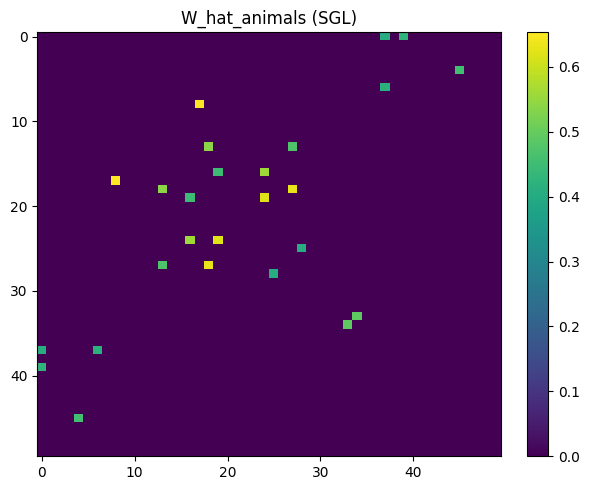

In [21]:
plt.figure(figsize=(6,5))
plt.imshow(W_hat_animals, aspect="auto")
plt.title("W_hat_animals (SGL)")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

In [22]:
W_hat_animals = adjacency_from_theta(Theta_hat_animals, thr_quantile=0.55)
G_hat_animals = nx.from_numpy_array(W_hat_animals)

[adjacency_from_theta] threshold = 0.2068


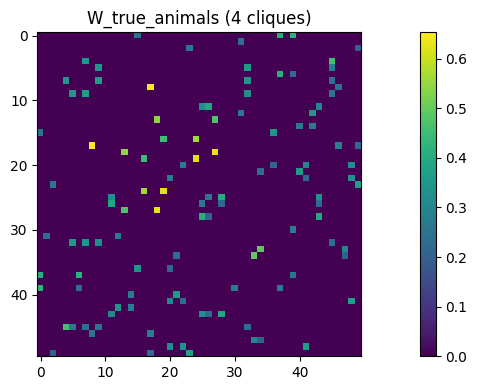

In [23]:
plt.figure(figsize=(12,4))


plt.imshow(W_hat_animals)
plt.title("W_true_animals (4 cliques)")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

In [24]:
print("Learned components (nx):", nx.number_connected_components(G_hat_animals))

Learned components (nx): 13


In [25]:
animal_names = [
    "antelope",
    "grizzly bear",
    "killer whale",
    "beaver",
    "dalmatian",
    "persian cat",
    "horse",
    "german shepherd",
    "blue whale",
    "siamese cat",
    "skunk",
    "mole",
    "tiger",
    "hippopotamus",
    "leopard",
    "moose",
    "spider monkey",
    "humpback whale",
    "elephant",
    "gorilla",
    "ox",
    "fox",
    "sheep",
    "seal",
    "chimpanzee",
    "hamster",
    "squirrel",
    "rhinoceros",
    "rabbit",
    "bat",
    "giraffe",
    "wolf",
    "chihuahua",
    "rat",
    "weasel",
    "otter",
    "buffalo",
    "zebra",
    "giant panda",
    "deer",
    "bobcat",
    "pig",
    "lion",
    "mouse",
    "polar bear",
    "collie",
    "walrus",
    "raccoon",
    "cow",
    "dolphin",
]
labels = {i: animal_names[i] for i in range(len(animal_names))}

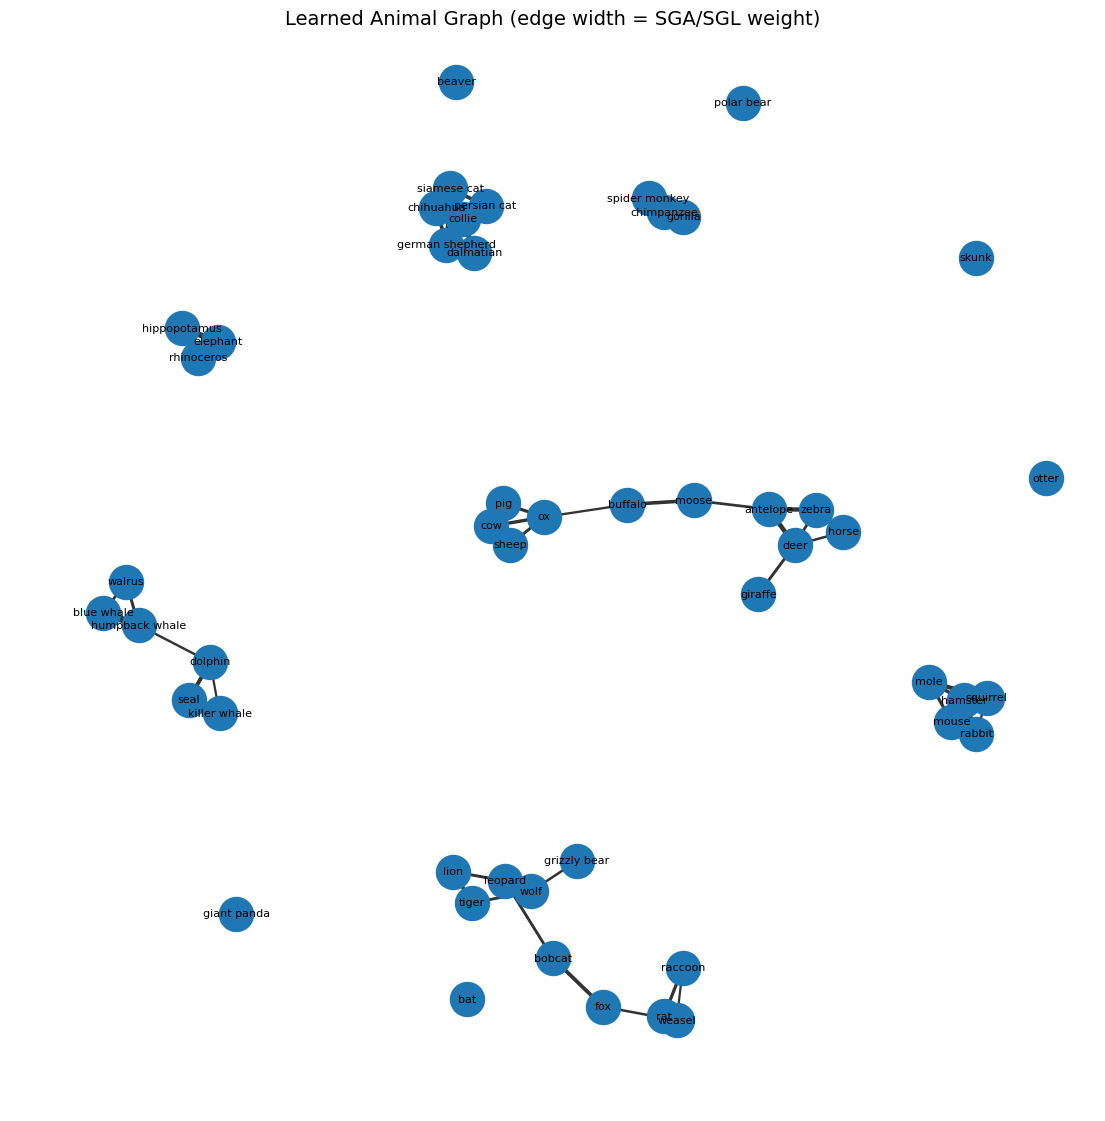

In [ ]:
plt.figure(figsize=(14, 14))

pos = nx.spring_layout(G_hat_animals, seed=0)

edges = list(G_hat_animals.edges())
weights = [G_hat_animals[u][v]["weight"] for u, v in edges]

weights = np.array(weights)
if len(weights) > 0:
    widths = 5.0 * weights / weights.max()
else:
    widths = 1.0

# Draw nodes
nx.draw_networkx_nodes(
    G_hat_animals,
    pos,
    node_size=600,
)

# Draw edges with widths = learned weights
nx.draw_networkx_edges(
    G_hat_animals,
    pos,
    edgelist=edges,
    width=widths,
    alpha=0.8,
)

# Draw labels
nx.draw_networkx_labels(
    G_hat_animals,
    pos,
    labels=labels,
    font_size=8,
)

plt.title("Learned Animal Graph (edge width = SGA/SGL weight)", fontsize=14)
plt.axis("off")
plt.show()


### Moons, circles and clusters

In [73]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

X_moons, labels_true_moons = make_moons(
    n_samples=100,
    noise=0.05,
    random_state=0
)


X_circles, labels_true_circles = make_circles(
    n_samples=200,
    factor=0.05,
    noise=0.05,
    random_state=0
)


def gaussian_similarity(X, sigma=None):

    D = cdist(X, X, metric="euclidean")
    
    if sigma is None:
        sigma = np.median(D[D > 0]) * 0.2

    W = np.exp(-(D * D) / (2 * (sigma*sigma)))
    np.fill_diagonal(W, 0.0)
    
    return W

def knn_sparsify(W, k):

    p = W.shape[0]
    Wk = np.zeros_like(W)
    
    for i in range(p):
        idx = np.argsort(W[i])[-k:]
        Wk[i, idx] = W[i, idx]
    
    return np.maximum(Wk, Wk.T)

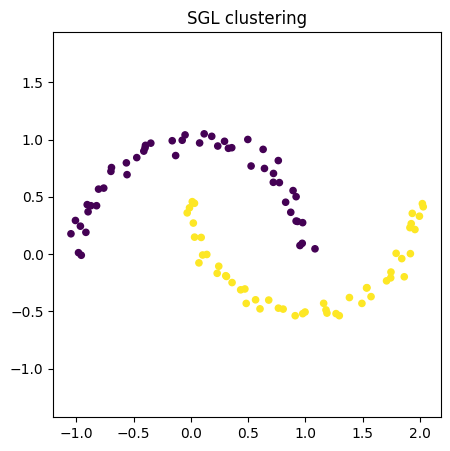

In [74]:
plt.figure(figsize=(5,5))
plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_true_moons, s=20)
plt.title("SGL clustering")
plt.axis("equal")
plt.show()

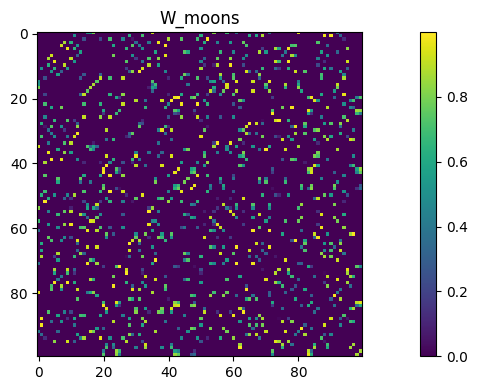

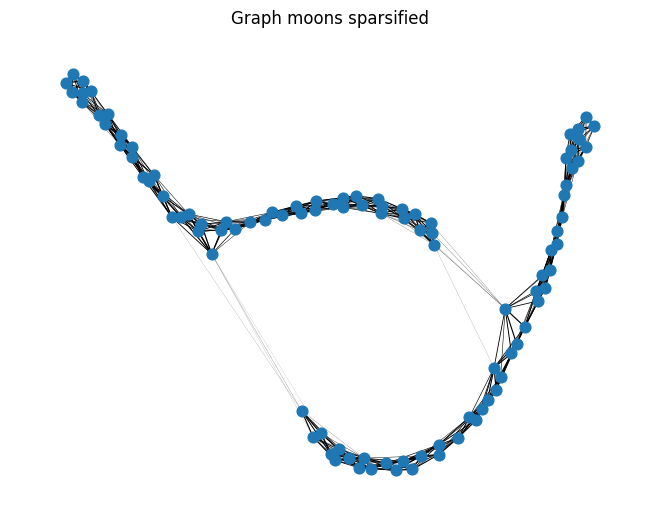

In [75]:
W_moons = gaussian_similarity(X_moons)
Theta_moons = laplacian_from_W(W_moons)
W_moons = knn_sparsify(W_moons, k=10)
G_moons = nx.from_numpy_array(W_moons)

plt.figure(figsize=(12,4))


plt.imshow(W_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_moons.edges())
p = W_moons.shape[0]
weights = np.array([G_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_moons, pos_moons, node_size=60, width=weights, edgelist=edges)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

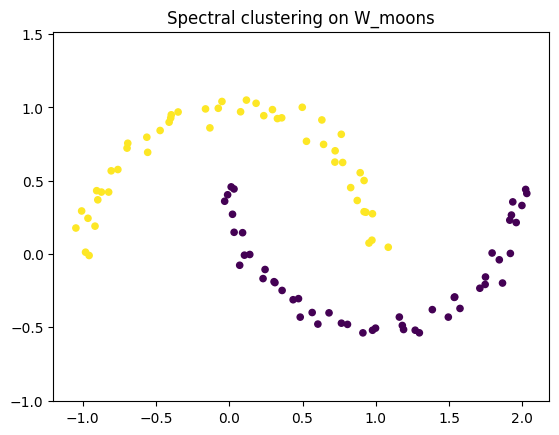

In [76]:
from sklearn.cluster import SpectralClustering

labels_sc = SpectralClustering(
    n_clusters=2,
    affinity="precomputed",
    random_state=0
).fit_predict(W_moons)

plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_sc, s=20)
plt.axis("equal")
plt.title("Spectral clustering on W_moons")
plt.show()

In [77]:
p = W_moons.shape[0]

L_init = laplacian_from_W(W_moons)
S_moons = np.linalg.pinv(W_moons) + 1/3 * np.eye(p)

Theta_hat_moons, w_hat_moons, U_hat_moons, lam_hat_mooons, _ = sgl_r_style(
    S=S_moons,
    k=2,
    alpha=0.1,     
    beta=150.0,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    reltol=1e-5,
    maxiter=1000,
)

[it=000] relchg(w)=9.983e-03, eig[k]=4.931e-02
[it=010] relchg(w)=2.623e-03, eig[k]=1.777e-01
[it=020] relchg(w)=2.224e-03, eig[k]=2.664e-01
[it=030] relchg(w)=2.146e-03, eig[k]=3.441e-01
[it=040] relchg(w)=2.126e-03, eig[k]=4.175e-01
[it=050] relchg(w)=2.110e-03, eig[k]=4.792e-01
[it=060] relchg(w)=2.078e-03, eig[k]=4.763e-01
[it=070] relchg(w)=2.021e-03, eig[k]=4.488e-01
[it=080] relchg(w)=1.972e-03, eig[k]=4.144e-01
[it=090] relchg(w)=1.982e-03, eig[k]=3.820e-01
[it=100] relchg(w)=2.052e-03, eig[k]=3.640e-01
[it=110] relchg(w)=2.233e-03, eig[k]=3.578e-01
[it=120] relchg(w)=2.281e-03, eig[k]=4.010e-01
[it=130] relchg(w)=2.116e-03, eig[k]=4.866e-01
[it=140] relchg(w)=1.945e-03, eig[k]=5.751e-01
[it=150] relchg(w)=1.759e-03, eig[k]=6.578e-01
[it=160] relchg(w)=1.586e-03, eig[k]=7.334e-01
[it=170] relchg(w)=1.437e-03, eig[k]=8.022e-01
[it=180] relchg(w)=1.317e-03, eig[k]=8.652e-01
[it=190] relchg(w)=1.222e-03, eig[k]=9.234e-01
[it=200] relchg(w)=1.147e-03, eig[k]=9.779e-01
[it=210] relc

In [78]:
W_hat_moons = adjacency_from_theta(Theta_hat_moons, thr_quantile=0.975)
G_hat_moons = nx.from_numpy_array(W_hat_moons)

[adjacency_from_theta] threshold = 0.1878


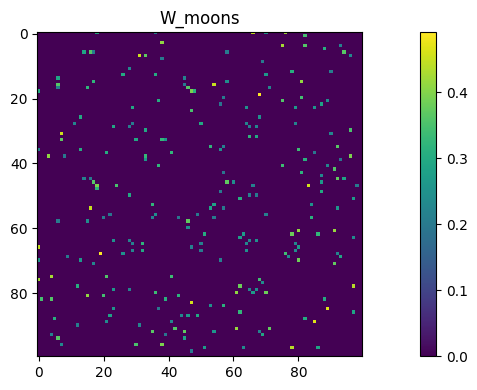

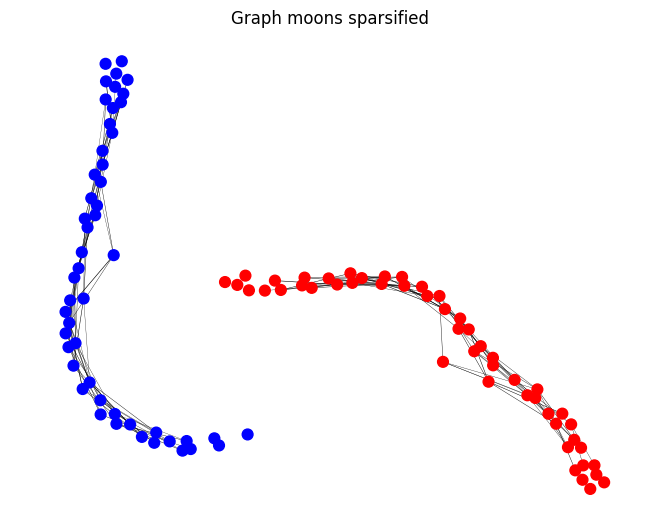

In [80]:
color_map = list()
for label in labels_true_moons:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_hat_moons.edges())
p = W_hat_moons.shape[0]
weights = np.array([G_hat_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_hat_moons, pos_moons, node_size=60, width=weights, edgelist=edges, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

In [81]:
re = relative_error(Theta_hat_moons, Theta_moons)
fs = f_score_from_thetas(Theta_hat_moons, Theta_moons, edges)
print(f"The residual score is: {re} and the f1 score is: {fs}")

The residual score is: 0.386798384037085 and the f1 score is: 0.19402985074626866


### Circles

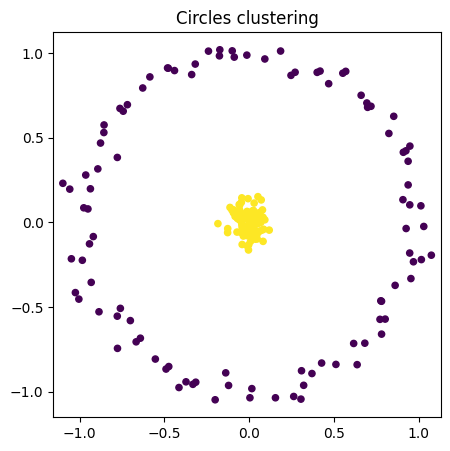

In [82]:
plt.figure(figsize=(5,5))
plt.scatter(X_circles[:,0], X_circles[:,1], c=labels_true_circles, s=20)
plt.title("Circles clustering")
plt.axis("equal")
plt.show()

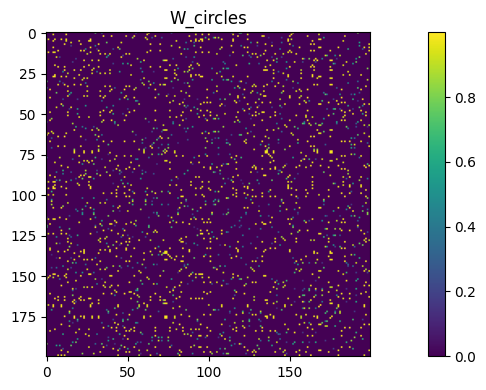

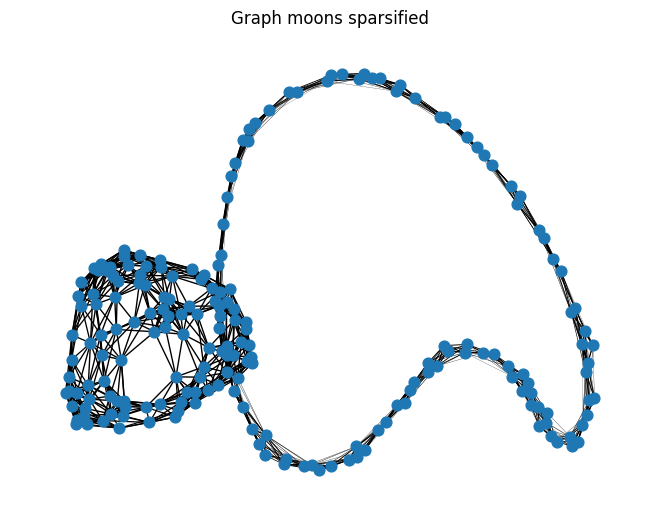

In [83]:
W_circles = gaussian_similarity(X_circles)
W_circles = knn_sparsify(W_circles, k=10)
G_circles = nx.from_numpy_array(W_circles)

plt.figure(figsize=(12,4))


plt.imshow(W_circles)
plt.title("W_circles")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_circles = nx.spring_layout(G_circles)
edges_circles = list(G_circles.edges())
p = W_circles.shape[0]
weights_circles = np.array([G_circles[u][v]["weight"] for u, v in edges_circles])

nx.draw(G_circles, pos_circles, node_size=60, width=weights_circles, edgelist=edges_circles)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

In [84]:
p = W_circles.shape[0]
S_circles = np.linalg.pinv(W_circles) + (1/3) * np.eye(p)

Theta_hat_circles, w_hat_circles, U_hat_circles, lam_hat_circles, _ = sgl_r_style(
    S=S_circles,
    k=2,
    alpha=0.1,     
    beta=1e2,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    reltol=1e-5,
    maxiter=500,
)

[it=000] relchg(w)=2.290e-04, eig[k]=4.431e-02
[it=010] relchg(w)=1.401e-04, eig[k]=2.623e-01
[it=020] relchg(w)=1.298e-04, eig[k]=4.369e-01
[it=030] relchg(w)=1.262e-04, eig[k]=5.916e-01
[it=040] relchg(w)=1.243e-04, eig[k]=7.324e-01
[it=050] relchg(w)=1.226e-04, eig[k]=8.623e-01
[it=060] relchg(w)=1.208e-04, eig[k]=9.835e-01
[it=070] relchg(w)=1.189e-04, eig[k]=1.098e+00
[it=080] relchg(w)=1.167e-04, eig[k]=1.207e+00
[it=090] relchg(w)=1.147e-04, eig[k]=1.311e+00
[it=100] relchg(w)=1.128e-04, eig[k]=1.411e+00
[it=110] relchg(w)=1.111e-04, eig[k]=1.507e+00
[it=120] relchg(w)=1.095e-04, eig[k]=1.600e+00
[it=130] relchg(w)=1.079e-04, eig[k]=1.691e+00
[it=140] relchg(w)=1.065e-04, eig[k]=1.778e+00
[it=150] relchg(w)=1.052e-04, eig[k]=1.863e+00
[it=160] relchg(w)=1.039e-04, eig[k]=1.946e+00
[it=170] relchg(w)=1.028e-04, eig[k]=2.027e+00
[it=180] relchg(w)=1.017e-04, eig[k]=2.106e+00
[it=190] relchg(w)=1.007e-04, eig[k]=2.183e+00
[it=200] relchg(w)=9.966e-05, eig[k]=2.259e+00
[it=210] relc

In [85]:
W_hat_circles = adjacency_from_theta(Theta_hat_circles)
G_hat_circles = nx.from_numpy_array(W_hat_circles)

[adjacency_from_theta] threshold = 1.236


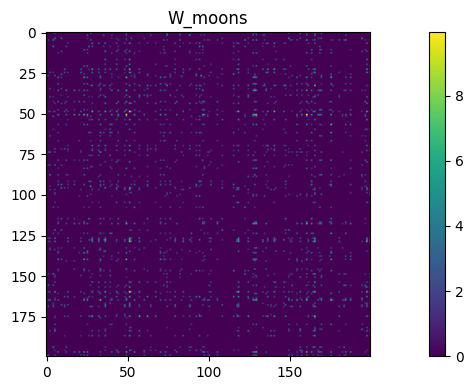

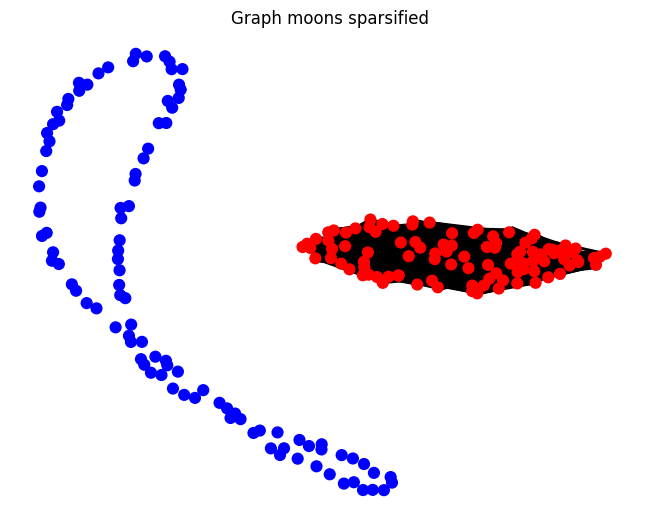

In [86]:
color_map = list()
for label in labels_true_circles:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_circles)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_circles = nx.spring_layout(G_circles)
edges_circles = list(G_hat_circles.edges())
p = W_hat_circles.shape[0]
weights_circles = np.array([G_hat_circles[u][v]["weight"] for u, v in edges_circles])

nx.draw(G_hat_circles, pos_circles, node_size=60, width=weights_circles, edgelist=edges_circles, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

Bretagne

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import networkx as nx

from math import asin, cos, radians, sin, sqrt

def fig_ax(figsize=(8,5)):
    fig, ax = plt.subplots(figsize=figsize)
    return fig, ax

def get_geodesic_distance(u, v):
    """
    u, v are (lon, lat) in degrees.
    Returns distance in km using Haversine.
    """
    lon1, lat1 = u
    lon2, lat2 = v

    R = 6371.0  # km
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)

    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

In [83]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset

data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

print("data_df:", data_df.shape, "columns:", list(data_df.columns))
print("stations_df:", stations_df.shape, "columns:", list(stations_df.columns))

The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

In [84]:
# If you already have this list, keep it:
# STATION_LIST = [...]

if "STATION_LIST" in globals() and len(STATION_LIST) > 0:
    keep_cond = stations_df.Nom.isin(STATION_LIST)
    stations_df = stations_df[keep_cond].copy()

    keep_cond = data_df.station_name.isin(STATION_LIST)
    data_df = data_df[keep_cond].reset_index(drop=True).copy()
else:
    print("No STATION_LIST found; keeping all stations in the dataset.")

No STATION_LIST found; keeping all stations in the dataset.


In [85]:
# Convert temperature from Kelvin to Celsius (your dataset uses `t`)
data_df["temp"] = data_df["t"] - 273.15

# Pivot: rows=time, columns=station
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name").sort_index()
print("temperature_df shape:", temperature_df.shape)

# Fill missing values simply (you can do better, but this is solid baseline)
temperature_df = temperature_df.ffill().bfill()

# Drop columns still having NaNs (if any)
temperature_df = temperature_df.dropna(axis=1)
print("After fill/drop:", temperature_df.shape)


temperature_df shape: (744, 55)
After fill/drop: (744, 51)


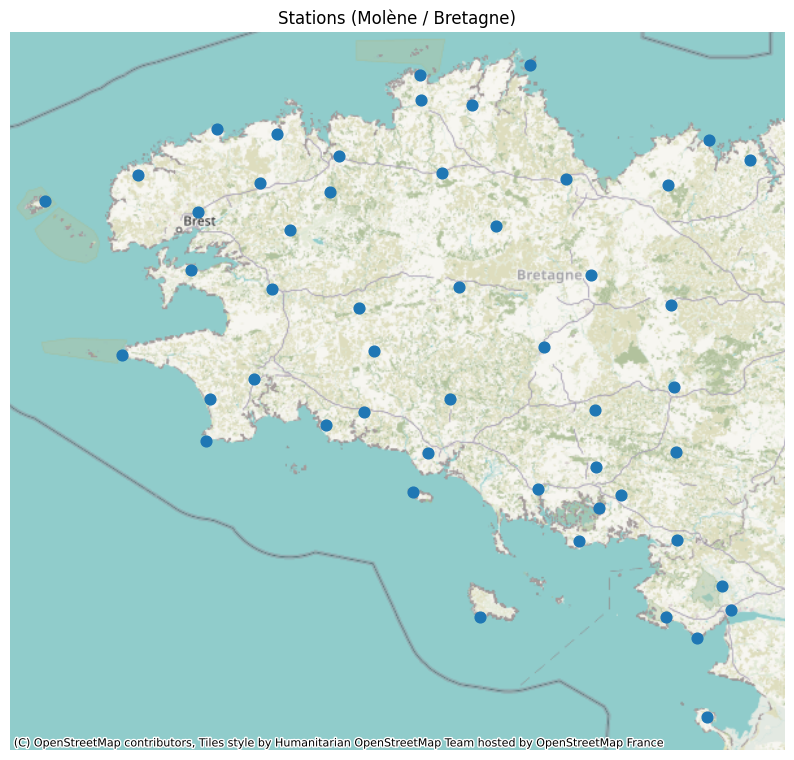

In [86]:
# CRS: if you already have CRS in your environment, keep it.
# Otherwise, use standard WGS84 then reproject to Web Mercator for basemap.
CRS = "EPSG:4326"

stations_sub = stations_df.copy()
stations_gdf = gpd.GeoDataFrame(
    stations_sub,
    geometry=gpd.points_from_xy(stations_sub.Longitude, stations_sub.Latitude),
    crs=CRS
)

# Keep only stations present in temperature_df columns
stations_gdf = stations_gdf[stations_gdf["Nom"].isin(temperature_df.columns)].copy()
stations_gdf = stations_gdf.set_index("Nom").loc[list(temperature_df.columns)].reset_index()

# Plot on basemap
stations_web = stations_gdf.to_crs(epsg=3857)

fig, ax = fig_ax(figsize=(10,10))
stations_web.plot(ax=ax, markersize=60)
cx.add_basemap(ax, crs=stations_web.crs.to_string(), zoom=8)
ax.set_axis_off()
ax.set_title("Stations (Molène / Bretagne)")
plt.show()

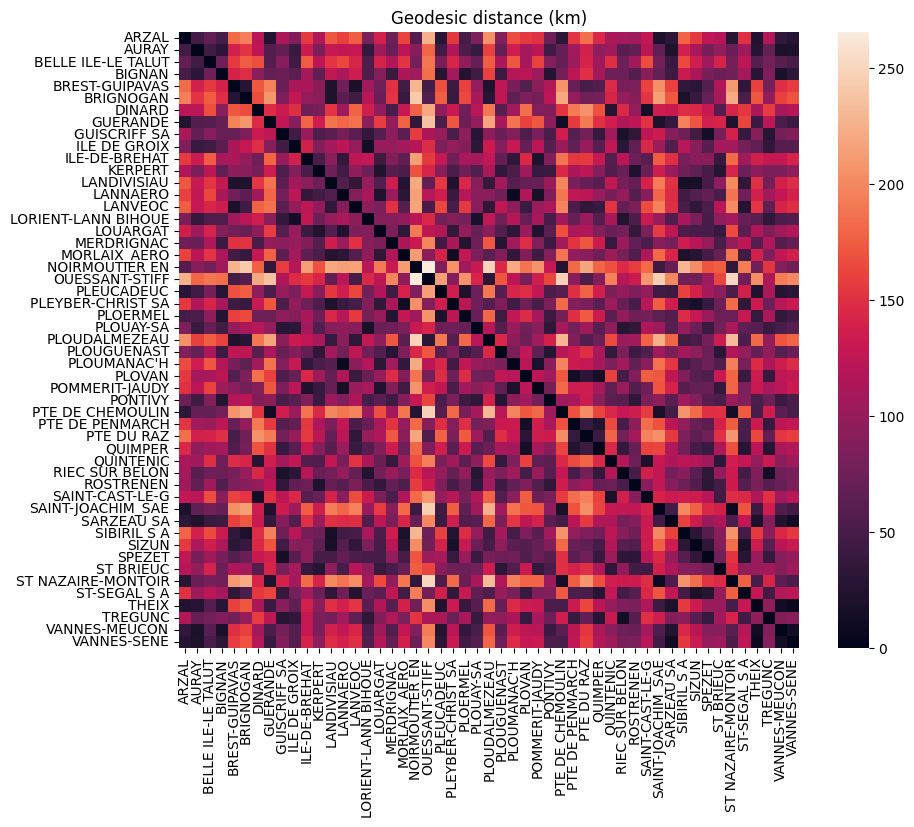

Closest stations: LANNAERO and PLOUMANAC'H
Distance: 7.846 km


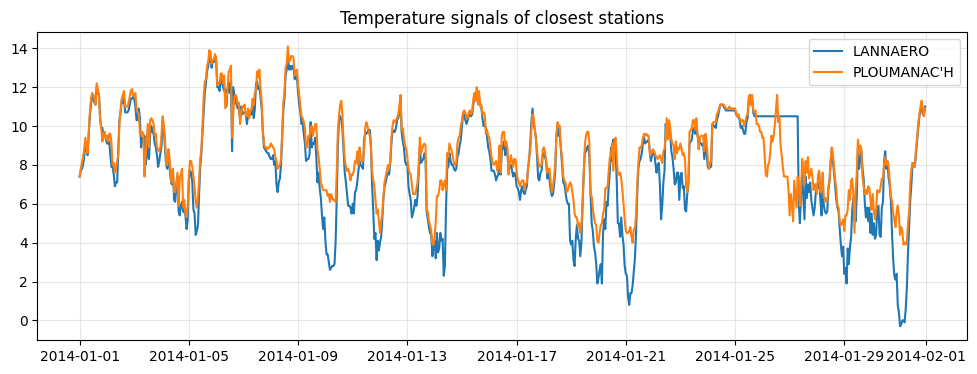

In [87]:
stations_np = stations_gdf[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax(figsize=(10,8))
sns.heatmap(
    dist_mat_square,
    xticklabels=stations_gdf["Nom"].values,
    yticklabels=stations_gdf["Nom"].values,
    ax=ax
)
ax.set_title("Geodesic distance (km)")
plt.show()

dist_tmp = dist_mat_square.copy()
np.fill_diagonal(dist_tmp, np.inf)
min_idx = np.argmin(dist_tmp)
i, j = np.unravel_index(min_idx, dist_tmp.shape)

station1 = stations_gdf.iloc[i]["Nom"]
station2 = stations_gdf.iloc[j]["Nom"]
min_distance = dist_tmp[i, j]

print(f"Closest stations: {station1} and {station2}")
print(f"Distance: {min_distance:.3f} km")

fig, ax = fig_ax(figsize=(12,4))
ax.grid(True, alpha=0.3)
ax.plot(temperature_df[station1], label=station1)
ax.plot(temperature_df[station2], label=station2)
ax.set_title("Temperature signals of closest stations")
ax.legend()
plt.show()

In [312]:
X = temperature_df.to_numpy()               # shape (T, p)
Xc = X - X.mean(axis=0, keepdims=True)
std = Xc.std(axis=0, keepdims=True)
Xz = Xc / std

S = (Xz.T @ Xz) / Xz.shape[0]

p = S.shape[0]
S_in = S + (1/3) * np.eye(p)   # same idea as you used: stabilize

k = 4
Theta_hat, w_hat, U_hat, lam_hat, hist = sgl_r_style(
    S=S_in,
    k=k,
    alpha=0.01,      # start with 0; later try 0.01..0.2
    beta=1e3,     # try 1e2..1e5
    eps=1e-2,
    c1=1e-7,
    c2=1e7,
    maxiter=1000,
    reltol=1e-5,
    verbose=True
)
print("done. iterations:", len(hist["relchg_w"]))

[it=000] relchg(w)=3.877e-02, eig[k]=1.687e+00
[it=010] relchg(w)=7.771e-03, eig[k]=1.275e+00
[it=020] relchg(w)=5.221e-03, eig[k]=1.029e+00
[it=030] relchg(w)=8.724e-03, eig[k]=7.343e-01
[it=040] relchg(w)=2.539e-03, eig[k]=6.934e-01
[it=050] relchg(w)=1.868e-03, eig[k]=6.749e-01
[it=060] relchg(w)=1.576e-03, eig[k]=6.604e-01
[it=070] relchg(w)=1.385e-03, eig[k]=6.489e-01
[it=080] relchg(w)=1.260e-03, eig[k]=6.390e-01
[it=090] relchg(w)=1.154e-03, eig[k]=6.299e-01
[it=100] relchg(w)=1.035e-03, eig[k]=6.220e-01
[it=110] relchg(w)=9.861e-04, eig[k]=6.150e-01
[it=120] relchg(w)=9.215e-04, eig[k]=6.085e-01
[it=130] relchg(w)=8.652e-04, eig[k]=6.026e-01
[it=140] relchg(w)=8.244e-04, eig[k]=5.973e-01
[it=150] relchg(w)=7.916e-04, eig[k]=5.927e-01
[it=160] relchg(w)=7.560e-04, eig[k]=5.884e-01
[it=170] relchg(w)=7.239e-04, eig[k]=5.844e-01
[it=180] relchg(w)=6.972e-04, eig[k]=5.805e-01
[it=190] relchg(w)=6.333e-04, eig[k]=5.768e-01
[it=200] relchg(w)=6.138e-04, eig[k]=5.732e-01
[it=210] relc

In [313]:
W_hat = adjacency_from_theta(Theta_hat, thr_quantile=0.95)

[adjacency_from_theta] threshold = 0.2211


In [314]:
G_hat = nx.from_numpy_array(W_hat)
components = list(nx.connected_components(G_hat))
print("num connected components:", len(components))

# map node -> cluster id
cluster_id = np.zeros(p, dtype=int)
for cid, comp in enumerate(components):
    for node in comp:
        cluster_id[node] = cid

num connected components: 25


p: 51
W_hat nnz: 56  /  2601
Nodes: 51 Edges: 28
Any NaN in coords? False
x range: -562942.6649415846 -231080.67253187345
y range: 5942835.878889969 6250321.900191935


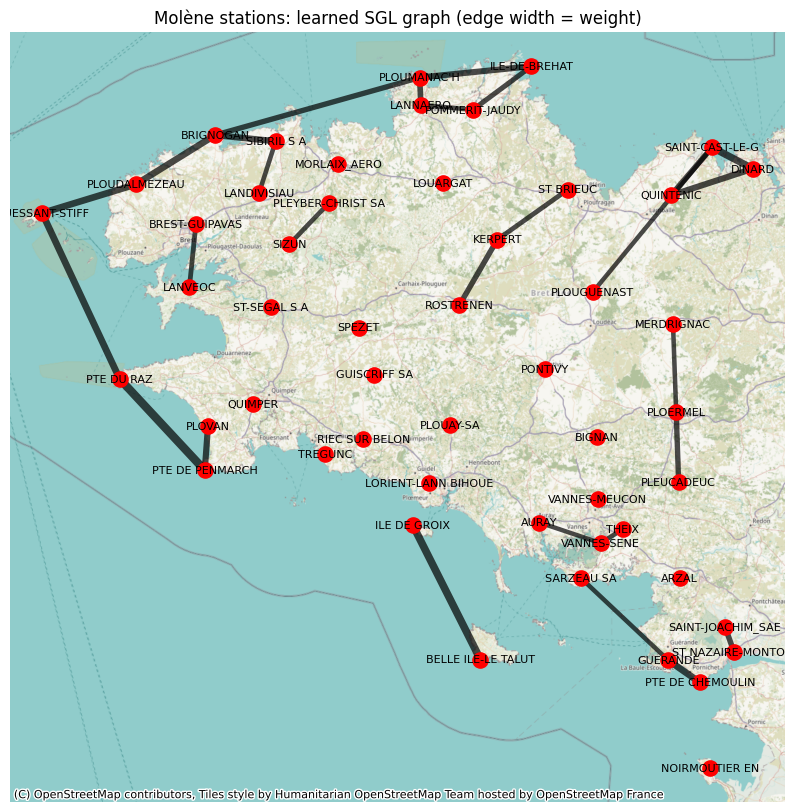

In [315]:
# ---- Sanity checks ----
print("p:", p)
print("W_hat nnz:", np.count_nonzero(W_hat), " / ", W_hat.size)

# Build graph from W_hat (NO threshold change here)
G_hat = nx.from_numpy_array(W_hat)

# If empty (no edges), lower the threshold automatically
if G_hat.number_of_edges() == 0:
    W_hat, thr = adjacency_from_theta(Theta_hat, thr_quantile=0.60)
    print("Graph was empty -> lowering thr_quantile to 0.60. New thr:", thr)
    G_hat = nx.from_numpy_array(W_hat)

print("Nodes:", G_hat.number_of_nodes(), "Edges:", G_hat.number_of_edges())

# ---- Geo positions in WebMercator ----
stations_plot = stations_gdf.copy()
stations_plot = gpd.GeoDataFrame(
    stations_plot,
    geometry=gpd.points_from_xy(stations_plot.Longitude, stations_plot.Latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Check coords
xy = np.array([(geom.x, geom.y) for geom in stations_plot.geometry])
print("Any NaN in coords?", np.isnan(xy).any())
print("x range:", xy[:,0].min(), xy[:,0].max())
print("y range:", xy[:,1].min(), xy[:,1].max())

pos = {i: (xy[i, 0], xy[i, 1]) for i in range(len(stations_plot))}

# Edge widths proportional to weights
edges = list(G_hat.edges())
weights = np.array([G_hat[u][v]["weight"] for u, v in edges], dtype=float) if len(edges) else np.array([])
widths = 6.0 * (weights / (weights.max() + 1e-12)) if len(weights) else []

# Labels
labels = {i: stations_gdf["Nom"].iloc[i] for i in range(len(stations_plot))}

# ---- Plot with correct axis limits BEFORE basemap ----
fig, ax = plt.subplots(figsize=(10, 10))

# Set extent to station bounding box (+ padding), otherwise basemap can show blank
pad = 15000  # meters
xmin, ymin, xmax, ymax = stations_plot.total_bounds
ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

# Basemap
cx.add_basemap(ax, crs=stations_plot.crs.to_string(), zoom=9)

# Draw edges then nodes
nx.draw_networkx_edges(G_hat, pos, ax=ax, edgelist=edges, width=widths, alpha=0.7)
nx.draw_networkx_nodes(G_hat, pos, ax=ax, node_size=120, node_color="red")
nx.draw_networkx_labels(G_hat, pos, ax=ax, labels=labels, font_size=8)

ax.set_axis_off()
ax.set_title("Molène stations: learned SGL graph (edge width = weight)")
plt.show()


In [316]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Haversine distance (km)
def haversine_km(lon1, lat1, lon2, lat2):
    R = 6371.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# (n,) arrays aligned with node indices
lats = stations_gdf["Latitude"].to_numpy()
lons = stations_gdf["Longitude"].to_numpy()

edges = list(G_hat.edges())
if len(edges) == 0:
    print("No edges in G_hat.")
else:
    geo_km = np.array([haversine_km(lons[u], lats[u], lons[v], lats[v]) for u, v in edges], dtype=float)
    print("Geodesic distance stats (km): min/mean/max =", geo_km.min(), geo_km.mean(), geo_km.max())


Geodesic distance stats (km): min/mean/max = 7.8461705732034055 25.704892345629307 65.04611552719902


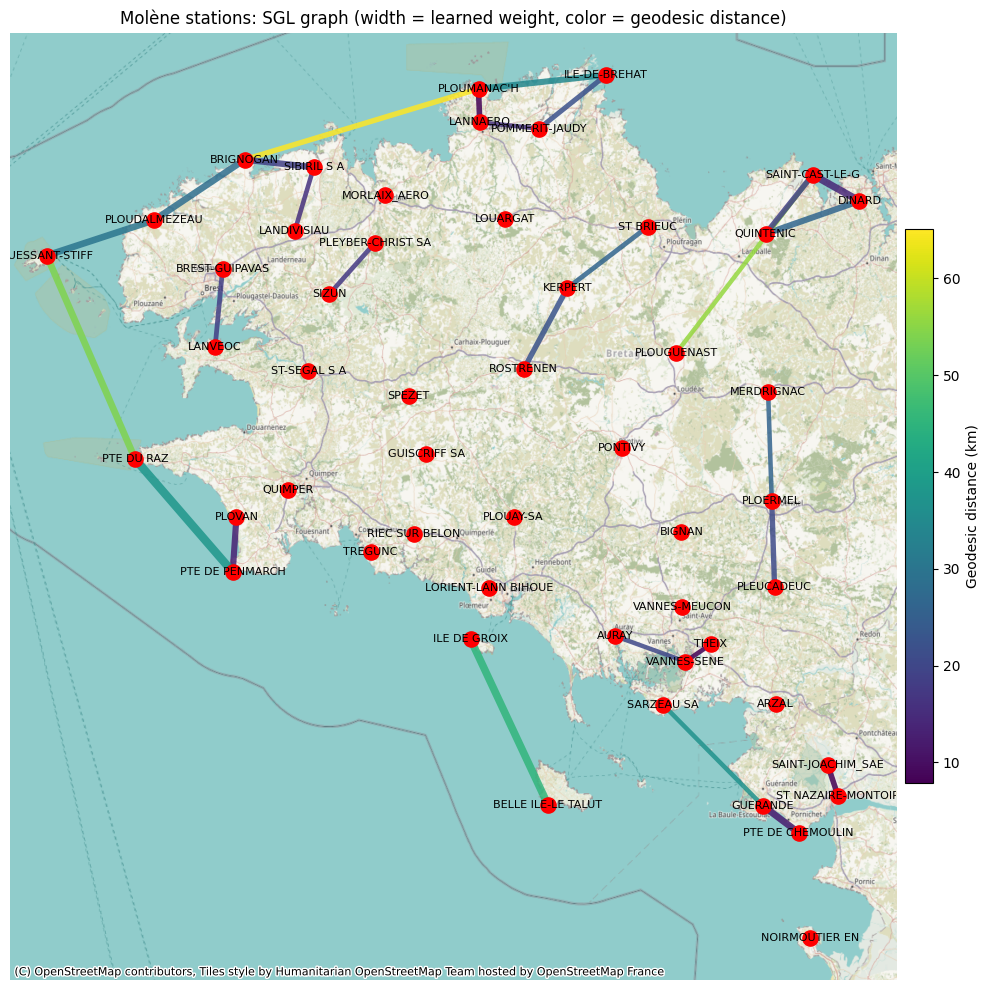

In [317]:
fig, ax = plt.subplots(figsize=(10, 10))

# extent like you already do
pad = 15000
xmin, ymin, xmax, ymax = stations_plot.total_bounds
ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

# basemap
cx.add_basemap(ax, crs=stations_plot.crs.to_string(), zoom=9)

# edge colors by distance
norm = mpl.colors.Normalize(vmin=float(geo_km.min()), vmax=float(geo_km.max()))
cmap = plt.cm.viridis
edge_colors = cmap(norm(geo_km))

# draw
nx.draw_networkx_edges(G_hat, pos, ax=ax, edgelist=edges, width=widths, edge_color=edge_colors, alpha=0.85)
nx.draw_networkx_nodes(G_hat, pos, ax=ax, node_size=120, node_color="red")
nx.draw_networkx_labels(G_hat, pos, ax=ax, labels=labels, font_size=8)

# colorbar legend for geodesic distance
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label("Geodesic distance (km)")

ax.set_axis_off()
ax.set_title("Molène stations: SGL graph (width = learned weight, color = geodesic distance)")
plt.tight_layout()
plt.show()

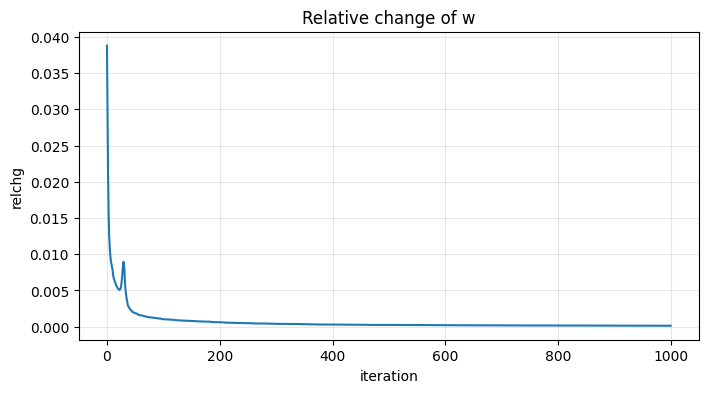

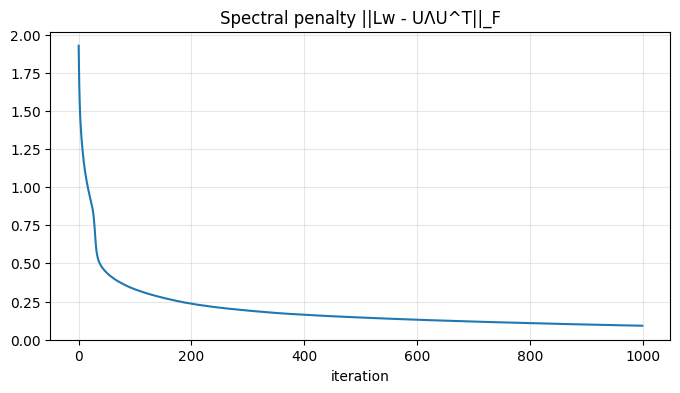

In [318]:
fig, ax = fig_ax(figsize=(8,4))
ax.plot(hist["relchg_w"])
ax.set_title("Relative change of w")
ax.set_xlabel("iteration")
ax.set_ylabel("relchg")
ax.grid(True, alpha=0.3)
plt.show()

fig, ax = fig_ax(figsize=(8,4))
ax.plot(hist["penalty"])
ax.set_title("Spectral penalty ||Lw - UΛU^T||_F")
ax.set_xlabel("iteration")
ax.grid(True, alpha=0.3)
plt.show()

Could we have predicted this result using only geodesic distances ?

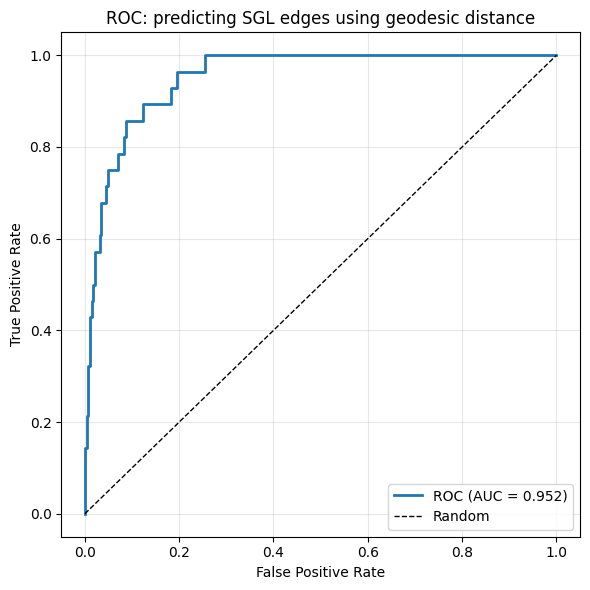

AUC = 0.9524286859892312


In [322]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_distance_roc(W_hat, dist_mat):
    """
    ROC curve:
      y = 1 if (i,j) is an edge in learned graph
      score = - geodesic distance
    """

    # upper triangle only
    iu = np.triu_indices(W_hat.shape[0], k=1)
    w = W_hat[iu]
    d = dist_mat[iu]

    # binary labels: edge vs non-edge
    y_true = (w > 0).astype(int)

    # scores: closeness
    scores = -d

    if y_true.sum() < 5:
        raise ValueError("Too few edges to compute ROC.")

    auc = roc_auc_score(y_true, scores)
    fpr, tpr, _ = roc_curve(y_true, scores)

    # ---- Plot ----
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC: predicting SGL edges using geodesic distance")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return auc

auc = plot_distance_roc(W_hat, dist_mat_square)
print("AUC =", auc)